In [18]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from fbprophet import Prophet
import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet, diagnostics
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, add_changepoints_to_plot, plot_plotly

In [2]:
ls

COVID-19-models.ipynb     coronavirus-in-italy/     covid19_data.csv
Covid-19-China.ipynb      coronavirus-in-italy.zip  global1/
Covid-19-US.ipynb         coronavirusdataset/       usa_1/
china-covid19-data/       covid19-in-usa/
china-covid19-data.zip    covid19-in-usa.zip


In [3]:
cd usa_1/

/Users/jinbiao.ji/mygithub/MLTSA_JJi/midterm/usa_1


In [4]:
ls

covid19-in-usa.zip                us_covid19_daily.csv
us-counties-covid-19-dataset.zip  us_states_covid19_daily.csv


In [5]:
c19_all_us = pd.read_csv('us_covid19_daily.csv')

In [6]:
c19_all_us['date'] = pd.to_datetime(c19_all_us['date'], format='%Y%m%d')

In [7]:
c19_all_us.head()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-04-30,56,1061101,5170081.0,2775.0,53793.0,111955.0,9486.0,4192.0,4712.0,...,111955.0,6233957,6231182,6231182,NaN,2041.0,2265.0,178613.0,27944.0,206557.0
1,2020-04-29,56,1033157,4991468.0,4832.0,54930.0,109690.0,9612.0,4093.0,4796.0,...,109690.0,6029457,6024625,6024625,NaN,2700.0,3382.0,203898.0,27565.0,231463.0
2,2020-04-28,56,1005592,4787570.0,4206.0,54940.0,106308.0,9491.0,3798.0,4760.0,...,106308.0,5797368,5793162,5793162,NaN,2198.0,2059.0,175209.0,24458.0,199667.0
3,2020-04-27,56,981134,4612361.0,4077.0,54971.0,104249.0,9655.0,3720.0,4867.0,...,104249.0,5597572,5593495,5593495,NaN,1163.0,3016.0,168567.0,21876.0,190443.0
4,2020-04-26,56,959258,4443794.0,4445.0,55050.0,101233.0,14831.0,2571.0,5121.0,...,101233.0,5407497,5403052,5403052,NaN,1095.0,2134.0,179387.0,27016.0,206403.0


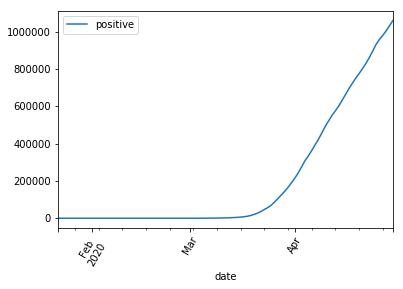

In [8]:
pd.plotting.register_matplotlib_converters()
c19_all_us.plot(x='date',y='positive',rot = 60)

In [53]:
c19_all_us['date'].iloc[-1]

Timestamp('2020-01-22 00:00:00')

### Daily Increase

(18283, 18392)

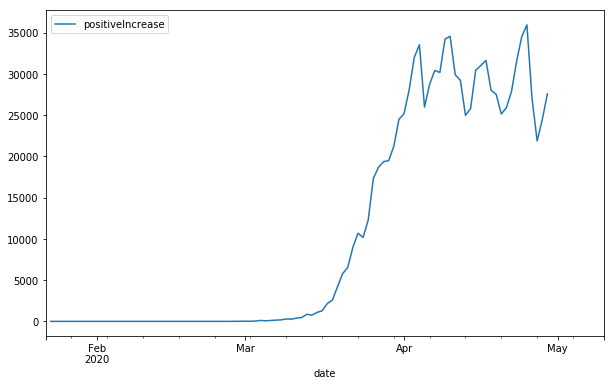

In [9]:
fig,ax=plt.subplots(figsize=(10,6))
c19_all_us[1:].plot(x='date',y='positiveIncrease',ax=ax)
ax.set_xlim(c19_all_us['date'].iloc[-1], pd.Timestamp('2020-05-10'))

### Step 1:

In [10]:
def func_logistic(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))

In [11]:
from scipy.optimize import curve_fit

In [12]:
confirmed_data=c19_all_us[::-1].reset_index().rename(columns={'date':'ds','positive':'y'})
confirmed_data.tail()


,index,ds,states,y,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
95,4,2020-04-26,56,959258,4443794.0,4445.0,55050.0,101233.0,14831.0,2571.0,...,101233.0,5407497,5403052,5403052,NaN,1095.0,2134.0,179387.0,27016.0,206403.0
96,3,2020-04-27,56,981134,4612361.0,4077.0,54971.0,104249.0,9655.0,3720.0,...,104249.0,5597572,5593495,5593495,NaN,1163.0,3016.0,168567.0,21876.0,190443.0
97,2,2020-04-28,56,1005592,4787570.0,4206.0,54940.0,106308.0,9491.0,3798.0,...,106308.0,5797368,5793162,5793162,NaN,2198.0,2059.0,175209.0,24458.0,199667.0
98,1,2020-04-29,56,1033157,4991468.0,4832.0,54930.0,109690.0,9612.0,4093.0,...,109690.0,6029457,6024625,6024625,NaN,2700.0,3382.0,203898.0,27565.0,231463.0
99,0,2020-04-30,56,1061101,5170081.0,2775.0,53793.0,111955.0,9486.0,4192.0,...,111955.0,6233957,6231182,6231182,NaN,2041.0,2265.0,178613.0,27944.0,206557.0


[]

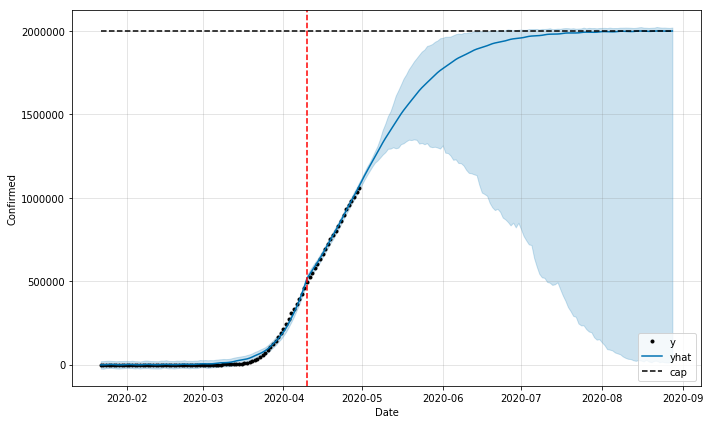

In [45]:
simlog = Prophet(growth='logistic',interval_width=0.95,n_changepoints=2,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    #changepoints = ['2020-02-27','2020-03-08','2020-04-05'],  
    changepoint_prior_scale=0.5)

confirmed_train = confirmed_data
confirmed_train['cap'] = 2000000
simlog.fit(confirmed_train)
future = simlog.make_future_dataframe(periods=120)
future['cap'] = 2000000
forecast = simlog.predict(future)

fig5, ax = plt.subplots(figsize=(10,6))
simlog.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed')
#
#ax.plot(confirmed_data[-10:].ds,confirmed_data[-10:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog, forecast,trend=False)
ax.legend()

ax.plot()

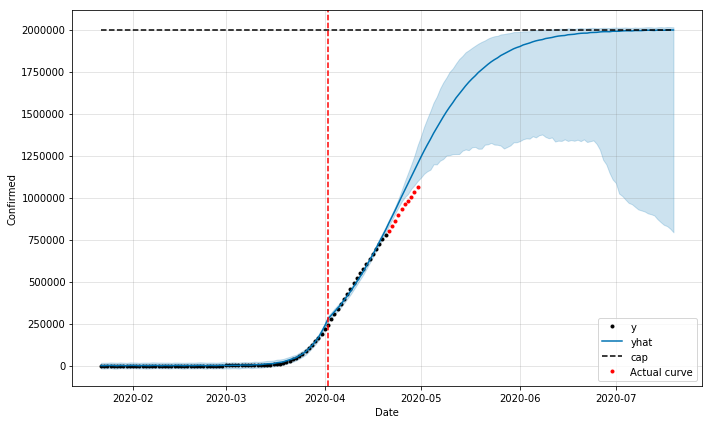

In [41]:
simlog = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    #changepoints = ['2020-02-27','2020-03-08','2020-04-05'],  
    changepoint_prior_scale=0.5)

confirmed_train = confirmed_data[:-10]
confirmed_train['cap'] = 2000000
simlog.fit(confirmed_train)
future = simlog.make_future_dataframe(periods=90)
future['cap'] = 2000000
forecast = simlog.predict(future)

fig5, ax = plt.subplots(figsize=(10,6))
simlog.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed')
#
ax.plot(confirmed_data[-10:].ds,confirmed_data[-10:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog, forecast,trend=False)
ax.legend()

**Figure.** 

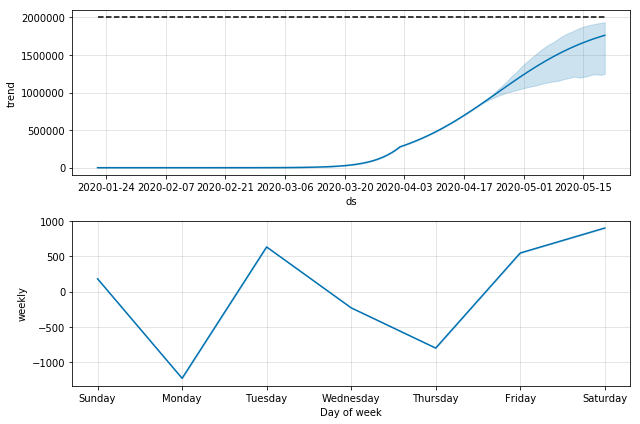

In [37]:
simlog.plot_components(forecast);

In [28]:
cvresult_simlog = cross_validation(simlog, horizon = '10 days')

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-02-25 00:00:00 and 2020-04-10 00:00:00


In [30]:
cvresult_simlog.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
95,2020-04-16,8.434453e+05,773646.804477,9.187661e+05,664129,2020-04-10
96,2020-04-17,9.040129e+05,807505.280529,9.967272e+05,695761,2020-04-10
97,2020-04-18,9.681755e+05,835798.877779,1.086259e+06,723776,2020-04-10
98,2020-04-19,1.029394e+06,872677.939135,1.166488e+06,751287,2020-04-10
99,2020-04-20,1.090277e+06,910550.792311,1.249097e+06,776419,2020-04-10


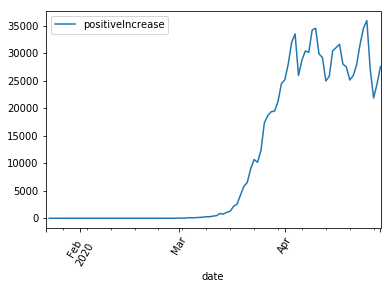

In [31]:
c19_all_us[1:].plot(x='date',y='positiveIncrease',rot = 60)